In [1]:
import numpy as np
from scipy.signal import resample_poly, firwin, bilinear, lfilter, spectrogram
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
x = np.fromfile('fm_rds_250k_1Msamples.iq', dtype=np.complex64)
sample_rate = 250e3
center_freq = 99.5e6

/usr/lib/python3/dist-packages/scipy/signal/_spectral_py.py:1814: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


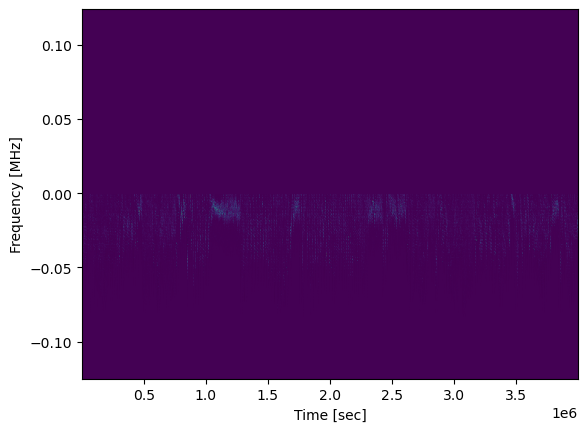

In [3]:
# Spectrogram
f, t, Sxx = spectrogram(x, sample_rate/1e6)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [MHz]')
plt.xlabel('Time [sec]')
plt.show()

In [4]:
# Quadrature Demod
x = 0.5 * np.angle(x[0:-1] * np.conj(x[1:]))

In [5]:
# Freq shift
N = len(x)
f_o = -57e3 # amount we need to shift by
t = np.arange(N)/sample_rate # time vector
x = x * np.exp(2j*np.pi*f_o*t) # down shift

In [6]:
# Low-Pass Filter
taps = firwin(numtaps=101, cutoff=7.5e3, fs=sample_rate)
x = np.convolve(x, taps, 'valid')

In [7]:
# Decimate by 10, now that we filtered and there wont be aliasing
x = x[::10]
sample_rate = 25e3

In [8]:
# Resample to 19kHz
x = resample_poly(x, 19, 25) # up, down
sample_rate = 19e3

In [9]:
samples = x
samples_interpolated = resample_poly(samples, 32, 1)
sps = 16
mu = 0.01
out = np.zeros(len(samples) + 10, dtype=np.complex64)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex64)
i_in = 0
i_out = 2
while i_out < len(samples) and i_in+32 < len(samples):
    out[i_out] = samples_interpolated[i_in*32 + int(mu*32)]
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.01*mm_val
    i_in += int(np.floor(mu))
    mu = mu - np.floor(mu) 
    i_out += 1
x = out[2:i_out]

In [10]:
x[0]

(0.0078002503+0.014601796j)

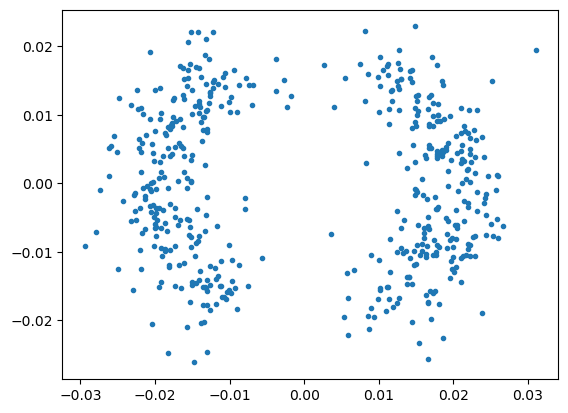

In [11]:
plt.plot(x[2500:3000].real, x[2500:3000].imag, '.')
plt.show()

In [12]:
samples = x # for the sake of matching the sync chapter
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 8.0
beta = 0.02
out = np.zeros(N, dtype=np.complex64)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * sample_rate / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi
x = out

In [13]:
x[0], x.shape

((0.0078002503+0.014601796j), (4748,))

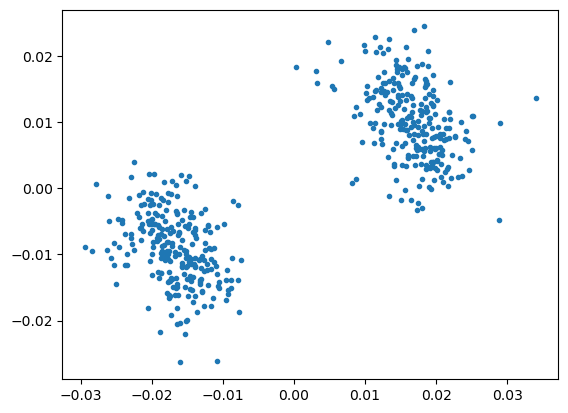

In [14]:
plt.plot(x[2500:3000].real, x[2500:3000].imag, '.')
plt.show()

In [15]:
 # Demod BPSK
bits = (np.real(x) > 0).astype(int)

In [16]:
bits = (bits[1:] - bits[0:-1]) % 2
bits = bits.astype(np.uint8) 

In [17]:
# Constants
syndrome = [383, 14, 303, 663, 748]
offset_pos = [0, 1, 2, 3, 2]
offset_word = [252, 408, 360, 436, 848]

# see Annex B, page 64 of the standard
def calc_syndrome(x, mlen):
    reg = 0
    plen = 10
    for ii in range(mlen, 0, -1):
        reg = (reg << 1) | ((x >> (ii-1)) & 0x01)
        if (reg & (1 << plen)):
            reg = reg ^ 0x5B9
    for ii in range(plen, 0, -1):
        reg = reg << 1
        if (reg & (1 << plen)):
            reg = reg ^ 0x5B9
    return reg & ((1 << plen) - 1) # select the bottom plen bits of reg

# Initialize all the working vars we'll need during the loop
synced = False
presync = False

wrong_blocks_counter = 0
blocks_counter = 0
group_good_blocks_counter = 0

reg = np.uint32(0) # was unsigned long in C++ (64 bits) but numpy doesn't support bitwise ops of uint64, I don't think it gets that high anyway
lastseen_offset_counter = 0
lastseen_offset = 0

# the synchronization process is described in Annex C, page 66 of the standard */
bytes_out = []
for i in range(len(bits)):
    # in C++ reg doesn't get init so it will be random at first, for ours its 0s
    # It was also an unsigned long but never seemed to get anywhere near the max value
    # bits are either 0 or 1
    reg = np.bitwise_or(np.left_shift(reg, 1), bits[i]) # reg contains the last 26 rds bits. these are both bitwise ops
    if not synced:
        reg_syndrome = calc_syndrome(reg, 26)
        for j in range(5):
            if reg_syndrome == syndrome[j]:
                if not presync:
                    lastseen_offset = j
                    lastseen_offset_counter = i
                    presync = True
                else:
                    if offset_pos[lastseen_offset] >= offset_pos[j]:
                        block_distance = offset_pos[j] + 4 - offset_pos[lastseen_offset]
                    else:
                        block_distance = offset_pos[j] - offset_pos[lastseen_offset]
                    if (block_distance*26) != (i - lastseen_offset_counter):
                        presync = False
                    else:
                        print('Sync State Detected')
                        wrong_blocks_counter = 0
                        blocks_counter = 0
                        block_bit_counter = 0
                        block_number = (j + 1) % 4
                        group_assembly_started = False
                        synced = True
            break # syndrome found, no more cycles

    else: # SYNCED
        # wait until 26 bits enter the buffer */
        if block_bit_counter < 25:
            block_bit_counter += 1
        else:
            good_block = False
            dataword = (reg >> 10) & 0xffff
            block_calculated_crc = calc_syndrome(dataword, 16)
            checkword = reg & 0x3ff
            if block_number == 2: # manage special case of C or C' offset word
                block_received_crc = checkword ^ offset_word[block_number]
                if (block_received_crc == block_calculated_crc):
                    good_block = True
                else:
                    block_received_crc = checkword ^ offset_word[4]
                    if (block_received_crc == block_calculated_crc):
                        good_block = True
                    else:
                        wrong_blocks_counter += 1
                        good_block = False
            else:
                block_received_crc = checkword ^ offset_word[block_number] # bitwise xor
                if block_received_crc == block_calculated_crc:
                    good_block = True
                else:
                    wrong_blocks_counter += 1
                    good_block = False

            # Done checking CRC
            if block_number == 0 and good_block:
                group_assembly_started = True
                group_good_blocks_counter = 1
                bytes = bytearray(8) # 8 bytes filled with 0s
            if group_assembly_started:
                if not good_block:
                    group_assembly_started = False
                else:
                    # raw data bytes, as received from RDS. 8 info bytes, followed by 4 RDS offset chars: ABCD/ABcD/EEEE (in US) which we leave out here
                    # RDS information words
                    # block_number is either 0,1,2,3 so this is how we fill out the 8 bytes
                    bytes[block_number*2] = (dataword >> 8) & 255
                    bytes[block_number*2+1] = dataword & 255
                    group_good_blocks_counter += 1
                    #print('group_good_blocks_counter:', group_good_blocks_counter)
                if group_good_blocks_counter == 5:
                    #print(bytes)
                    bytes_out.append(bytes) # list of len-8 lists of bytes
            block_bit_counter = 0
            block_number = (block_number + 1) % 4
            blocks_counter += 1
            if blocks_counter == 50:
                if wrong_blocks_counter > 35: # This many wrong blocks must mean we lost sync
                    print("Lost Sync (Got ", wrong_blocks_counter, " bad blocks on ", blocks_counter, " total)")
                    synced = False
                    presync = False
                else:
                    print("Still Sync-ed (Got ", wrong_blocks_counter, " bad blocks on ", blocks_counter, " total)")
                blocks_counter = 0
                wrong_blocks_counter = 0

Sync State Detected
Still Sync-ed (Got  12  bad blocks on  50  total)
Still Sync-ed (Got  2  bad blocks on  50  total)
Still Sync-ed (Got  0  bad blocks on  50  total)
